Implementation of ULMFit for tweet classification

Installing pytorch and fastai

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 25kB/s 


Importing Libraries

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
from google.colab import files
files.upload()    #uploading train data

In [0]:
train_data = pd.read_csv('train_E6oV3lV.csv')
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [0]:
from google.colab import files
files.upload()   #uploading test data

In [0]:
test_data = pd.read_csv('test_tweets_anuFYb8.csv')
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [0]:
#test data size
test_data.shape

(17197, 2)

Text Preprocessing

In [0]:
#cleaning the text
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

def preprocessing(dataset):
    corpus=[]
    for i in range(0,len(dataset)):
        clean_tweet = re.sub("@[\w]*",' ',dataset['tweet'][i])     # removing @ that are user tags.
        clean_tweet = re.sub('[^a-zA-Z]', ' ', clean_tweet)       # retaining alphabets only
        #clean_tweet = clean_tweet.lower()
        #clean_tweet = clean_tweet.split()
        #clean_tweet = [word for word in clean_tweet if not word in set(stopwords.words('english'))]  
        #clean_tweet =' '.join(clean_tweet)
        corpus.append(clean_tweet)
    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#calling the preprocessing function and passing the entire dataset 
train_clean = preprocessing(train_data)
test_clean = preprocessing(test_data)

In [0]:
#cleaned tweet in dataframe 
train_df = pd.DataFrame()
train_df['tweet'] = train_clean
train_df['label'] = train_data['label']

test_df = pd.DataFrame()
test_df['tweet'] = test_clean

print(train_df.shape),print(test_df.shape)

(31962, 2)
(17197, 1)


(None, None)

In [0]:
train_df.head()

,tweet,label
0,when a father is dysfunctional and is so se...,0
1,thanks for lyft credit i can t use cause ...,0
2,bihday your majesty,0
3,model i love u take with u all the time in ...,0
4,factsguide society now motivation,0


In [0]:
#there are words with length equal to 1 that actually donot provide any information. So removing them from both train and test set
train_df['tweet'] = train_df['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=2]))
test_df['tweet'] = test_df['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=2]))
train_df.head()

,tweet,label
0,when father is dysfunctional and is so selfish...,0
1,thanks for lyft credit can use cause they don ...,0
2,bihday your majesty,0
3,model love take with all the time in ur,0
4,factsguide society now motivation,0


In [0]:
#splitting the train and validation set
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(train_df,test_size = 0.20, random_state = 7,stratify = train_df['label'])

In [0]:
df_trn.head()

,tweet,label
7121,my books aren here,0
23276,so did get my son seat with my wife thanks et ...,0
31475,model love take with all the time in ur,0
2461,it so soothing to see on tv after bad bad day ...,0
17060,sesalefueeadele pa hello adele longboard love ...,0


In [0]:
df_trn['label'].value_counts()

0    23775
1     1794
Name: label, dtype: int64

In [0]:
df_val['label'].value_counts()

0    5945
1     448
Name: label, dtype: int64

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val,text_cols='tweet', label_cols='label',path = "")


In [0]:
data_lm.show_batch()


idx,text
0,xxbos it friday friday construction fun smile tired cute xxbos just the of us me selfie myfriend loveher xxunk smile xxunk xxbos this guy money man sold quickly via my xxunk collector switzerland xxunk xxbos instagram xxunk when you don want to read stupid childish rude comments xxbos model love take with all the time in ur xxbos when find yourself up watching food videos just made myself hungry xxbos
1,to ensure quality and service are xxunk and continues to be the norm customers nexus xxunk xxbos what is detoxdiet altwaystoheal healthy xxbos whoa that tough make america gr again xxunk xxunk xxbos graphics are on and she looking good xxunk xxunk xxunk xxbos epic fail xxbos there big difference between being and comfoable which one are you xxbos my new furbaby familylife awesome cool coolness cute loveit cuteness love
2,simulator you need to do to adapt to the environment the need to tear the city mat xxbos sorry to hear that as my mum is years and has been in care home for last eight months have that to come xxbos pa of trumps tweets after his xxunk won if wanted now using putin to project his anger cuz we hate him xxbos tonight is the night strictly to
3,xxbos in two weeks ve lost st lb on juiceplus and ve finally fit into the shos got for my holiday march and never fit in xxbos ex in cu xxbos coffee bacon xxunk writing and catching up with and blog posts and thankful xxbos hot fuss is having xxunk on vinyl tomorrow and so excited and it ll be such an amazing bihday present to myself xxbos mango wood
4,xxunk bigthingscoming xxbos if get retweets will show my xxunk lt boobies boob retweet xxbos think xxunk is the christmas movie xxunk was talking about please make official announcement xxbos because he can shoot for shit never could xxbos very bihday to our rajkuamar sir have great success ahead xxbos are you having as nice day as these happy grapes weekend sunshine sun grapes saturday fun wine xxbos tgif ff


In [0]:
#first 20 unique tokens in order of their frequency called vocabulary.
data_lm.vocab.itos[:40]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 'to',
 'you',
 'and',
 'in',
 'for',
 'of',
 'is',
 'my',
 'it',
 'love',
 'this',
 'on',
 'with',
 'be',
 'day',
 'that',
 'all',
 'so',
 'are',
 'me',
 'amp',
 'happy',
 'your',
 'have',
 'at',
 'we',
 'can',
 'am',
 'just',
 'will']

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val,test_df = test_df, vocab=data_lm.train_ds.vocab,text_cols='tweet', label_cols='label', bs=32)

Fine tuning the pre trained model

In [0]:
learn = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=0.2)


In [0]:
#finding optimal learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


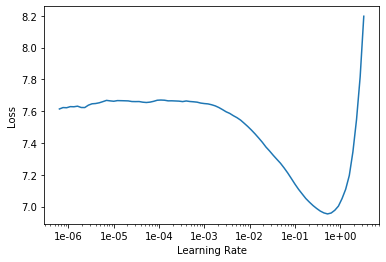

In [0]:
learn.recorder.plot()

In [0]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.082901,5.429324,0.188264,00:08


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.230158,5.028655,0.240331,00:10
1,4.906475,4.843226,0.258882,00:10
2,4.413151,4.811626,0.264192,00:10
3,3.804769,4.889307,0.269267,00:10
4,3.348214,4.987091,0.266741,00:10


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.321991,5.019737,0.264767,00:10
1,3.581357,5.013128,0.256520,00:10
2,3.824702,5.002100,0.251974,00:10
3,3.848895,5.036735,0.252620,00:10
4,3.462403,5.121836,0.261055,00:10
5,2.870102,5.313288,0.264274,00:10
6,2.257231,5.594893,0.250952,00:10
7,1.718496,5.660025,0.266729,00:10
8,1.363878,5.700542,0.268022,00:10
9,1.206441,5.701058,0.268456,00:10


In [0]:
# check how the language model performs
learn.predict("What should", n_words=10)

'What should have done so in the civil jrock trump stands for'

In [0]:
#saving the model
learn.save_encoder('embed_enc')

In [0]:
#using text_classifier_learner an loading the language model trained above
classifier = text_classifier_learner(data_clas,arch=AWD_LSTM, drop_mult=0.2)
classifier.load_encoder('embed_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25569 items)
x: TextList
xxbos my books aren here,xxbos so did get my son seat with my wife thanks et al far better service on twitter than in real life,xxbos model love take with all the time in ur,xxbos it so soothing to see on tv after bad bad day xxunk,xxbos xxunk pa hello adele xxunk love me instagood felizdomingo
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (6393 items)
x: TextList
xxbos peace tbt bihday throwback,xxbos just minutes and counting till my favourite program of the night comes on,xxbos celebrate the second chance in paperback author,xxbos can believe leaving xxunk on sunday these years have gone too quick uni moving,xxbos words of terror xxunk conce is cancelled love you thank you for playing xxunk for me days
y: CategoryList
0,0,0,0,0
Path: .;

Test: LabelList (17197 items)
x: TextList
xxbos xxunk xxunk requires passion dedication xxunk to find xxunk,xxbos white xxunk want everyone to see the new birds mo

In [0]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-01
Min loss divided by 10: 4.37E-02


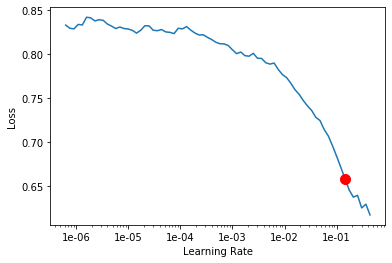

In [0]:
classifier.recorder.plot(skip_end = 10,suggestion = True)

In [0]:
classifier.fit_one_cycle(1, 1e-1)


epoch,train_loss,valid_loss,accuracy,time
0,0.165649,0.179131,0.940404,00:12


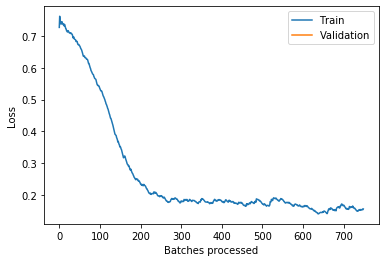

In [0]:
#classifier.recorder.plot_losses()

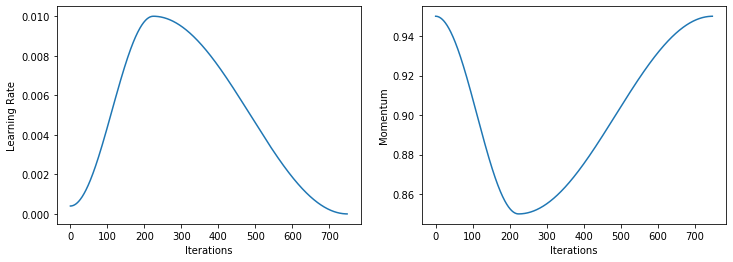

In [0]:
#classifier.recorder.plot_lr(show_moms=True)


In [0]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1,slice(5e-3/2.,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.141241,0.138315,0.952604,00:14


In [0]:
classifier.unfreeze()
classifier.fit_one_cycle(10,slice(5e-3/2.,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.097736,0.128915,0.956984,00:22
1,0.109672,0.155923,0.958079,00:22
2,0.110550,0.357223,0.957923,00:22
3,0.077093,0.153326,0.950258,00:23
4,0.069839,0.151509,0.957141,00:22
5,0.034415,0.140583,0.963554,00:22
6,0.025382,0.187112,0.963085,00:22
7,0.005351,0.464784,0.965587,00:23
8,0.001646,0.255935,0.966369,00:22
9,0.001569,0.250831,0.966839,00:23


In [0]:
# get predictions for validation set
preds, targets = classifier.get_preds()

In [0]:
predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,5879,146
1,66,302


Prediction for test data

In [0]:
test_df.head()

,tweet,label
0,studiolife aislife requires passion dedication...,0
1,white supremacists want everyone see new birds...,0
2,safe ways heal acne altwaystoheal healthy healing,0
3,hp cursed child book reservations already yes ...,0
4,rd bihday amazing hilarious nephew eli ahmir u...,0


In [0]:
data_clas.add_test(test_df["tweet"])


In [0]:
test_preds, _ = classifier.get_preds(DatasetType.Test, 
                                     ordered=True)

In [0]:
test_preds

tensor([[9.9996e-01, 4.1013e-05],
        [9.9994e-01, 6.2646e-05],
        [9.9966e-01, 3.4404e-04],
        ...,
        [9.9948e-01, 5.1824e-04],
        [9.9995e-01, 4.5956e-05],
        [9.9998e-01, 1.9219e-05]])

In [0]:
test_predictions = np.argmax(test_preds, axis = 1)
test_predictions

tensor([0, 0, 0,  ..., 0, 0, 0])

In [0]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['label'] = test_predictions

In [0]:
submission.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [0]:
submission['label'].value_counts()

0    16149
1     1048
Name: label, dtype: int64

In [0]:
submission.to_csv('tweet_submit5.csv',index = False)

With only little learning and minimum amount of code, I was able to get the F1 score of 0.74